# Regression of 2D data with a multilayer perceptron

In [71]:
import numpy as np
import matplotlib.pyplot as plt
#3D plots
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
#figures in notebook
%matplotlib inline
#larger figures
plt.rcParams['figure.figsize'] = [10, 5]

In [49]:
x=np.array([[3.0,5],[5,1],[11,6],[6,7],[2,4],[12,4],[8,2],[8,4],[10,4],[6,1]])
x= x/np.amax(x, axis=0)
y=np.array([[75.0],[82],[93],[81],[55],[62],[96],[85],[51],[81]])
y = y/100.0

# Implementation of the Network

The goal of this network is to fit/overfit 3D data with a 2 dimensional input and a 1 dimensional output. The network uses a L2 loss, it is optimized with full batch Gradient Descent or full barch Gradient Descent with momentum.

In [50]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))
    
class Neural_Network(object):
    def __init__(self,learningRateGrad=3.0,momentum=0.1,loopsGrad=1000,hiddenLayers=3,hiddenLayers2=3):
        #Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = hiddenLayers
        self.hiddenLayerSize2 =hiddenLayers2
        
        self.learningRate = learningRateGrad
        self.maxRange=loopsGrad
        self.costArray=[]
        self.momentum = momentum

        #Initialize Weights
        np.random.seed(5)
        self.W1 = np.random.rand(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.rand(self.hiddenLayerSize,self.hiddenLayerSize2)
        self.W3 = np.random.rand(self.hiddenLayerSize2,self.outputLayerSize)
        
        self.B2 = np.random.rand(1,self.hiddenLayerSize)
        self.B3 = np.random.rand(1,self.hiddenLayerSize2)
        self.Boutput = np.random.rand(1,self.outputLayerSize)
        
    def forward(self, X):
        self.z2 = np.dot(X, self.W1) + self.B2
        self.a2 = sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.W2) + self.B3
        self.a3 = sigmoid(self.z3)
        self.z4 = np.dot(self.a3,self.W3) + self.Boutput
        yHat = sigmoid(self.z4)
        return yHat
    
    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        return(np.sum(0.5*(y-self.yHat)**2))
        
    def costFunctionPrime(self, X, y):
        '''Computes derivative of the error (yHat) and backpropagate it throught the network'''
        #Optaining the expected values for the set of examples
        self.yHat = self.forward(X)
        
        #Bit of calculus for backpropagation
        #The derivative of the error to backpropagate is yhat - y
        #delta is the contribution to the error of the activation of the last layer as well as the one of the biais
        #dJdWi is the contribution of the weights to the error
        
        #Could be implemented recursively but I don't really like recursion.
        delta4 = np.multiply(-(y-self.yHat), sigmoidPrime(self.z4))
        dJdW3 = np.dot(self.a3.T, delta4)
        
        delta3 = np.dot(delta4, self.W3.T)*sigmoidPrime(self.z3)
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)
        
        #Returns the contribution of the weigths and biaises so they can be updated in the train function
        return dJdW1, dJdW2, dJdW3, np.sum(delta2), np.sum(delta3), np.sum(delta4)
    
    def train(self,x,y):
        for i in range(self.maxRange):
            dJdW1, dJdW2, dJdW3, delta2, delta3, delta4 = self.costFunctionPrime(x, y)
            self.W1 += -self.learningRate*dJdW1
            self.W2 += -self.learningRate*dJdW2
            self.W3 += -self.learningRate*dJdW3

            self.B2 += -self.learningRate*delta2
            self.B3 += -self.learningRate*delta3
            self.Boutput += -self.learningRate*delta4
            self.costArray.append(self.costFunction(x,y))
    
    def trainMomentum(self,x,y):
        '''Training method using momentum SGD'''
        #Initialize memory
        precedentUp1=np.zeros([self.inputLayerSize,self.hiddenLayerSize])
        precedentUp2=np.zeros([self.hiddenLayerSize,self.hiddenLayerSize2])
        precedentUp3=np.zeros([self.hiddenLayerSize2,self.outputLayerSize])
        precedentUpBias2=np.zeros([1,self.hiddenLayerSize])
        precedentUpBias3=np.zeros([1,self.hiddenLayerSize2])
        precedentUpBiasOut=np.zeros([1,self.outputLayerSize])
        
        #maxRange is the number of training iteration
        for i in range(self.maxRange):
            #Compute the initial update
            dJdW1, dJdW2, dJdW3, delta2, delta3, delta4 = self.costFunctionPrime(x, y)
            update1 = self.learningRate*dJdW1
            update2 = self.learningRate*dJdW2
            update3 = self.learningRate*dJdW3
            updateBias2 = self.learningRate*delta2
            updateBias3 = self.learningRate*delta3
            updateBiasOut = self.learningRate*delta4
            
            #Compute velocity
            velocity1 = precedentUp1*self.momentum
            velocity2 = precedentUp2*self.momentum
            velocity3 = precedentUp3*self.momentum
            velocityBias2 = precedentUpBias2*self.momentum
            velocityBias3 = precedentUpBias3*self.momentum
            velocityBiasOut = precedentUpBiasOut*self.momentum
            
            #Update the weights and biases by correcting the update with the velocity
            self.W1 = self.W1 - velocity1 - update1
            self.W2 = self.W2 - velocity2 - update2
            self.W3 = self.W3 - velocity3 - update3
            self.B2 = self.B2 - velocityBias2 - updateBias2
            self.B3 = self.B3 - velocityBias3 - updateBias3
            self.Boutput = self.Boutput - velocityBiasOut - updateBiasOut
            
            #Save the last update for the next velocity
            precedentUp1 = update1
            precedentUp2 = update2
            precedentUp3 = update3
            precedentUpBias2 = updateBias2
            precedentUpBias3 = updateBias3
            precedentUpBiasOut = updateBiasOut
            self.costArray.append(self.costFunction(x,y))

# Loading the dataset

In [51]:
# Import data
co2_df = pd.read_csv('global.csv')
temp_df = pd.read_csv('annual.csv')

# Clean data
co2_df = co2_df.iloc[:,:2]                     # Keep only total CO2
co2_df = co2_df.loc[co2_df['Year'] >= 1960]   # Keep only 1960 - 2010
co2_df.columns=['Year','CO2']                # Rename columns
co2_df = co2_df.reset_index(drop=True)                # Reset index

temp_df = temp_df[temp_df.Source != 'GISTEMP']                              # Keep only one source
temp_df.drop('Source', inplace=True, axis=1)                                # Drop name of source
temp_df = temp_df.reindex(index=temp_df.index[::-1])                        # Reset index
temp_df = temp_df.loc[temp_df['Year'] >= 1960].loc[temp_df['Year'] <= 2010]   # Keep only 1960 - 2010
temp_df.columns=['Year','Temperature']                                      # Rename columns
temp_df = temp_df.reset_index(drop=True)                                             # Reset index

In [52]:
climate_change_df = pd.concat([co2_df, temp_df.Temperature], axis=1)
climate_change_df.head()

,Year,CO2,Temperature
0,1960,2569,0.0204
1,1961,2580,0.0775
2,1962,2686,0.0888
3,1963,2833,0.1068
4,1964,2995,-0.1495


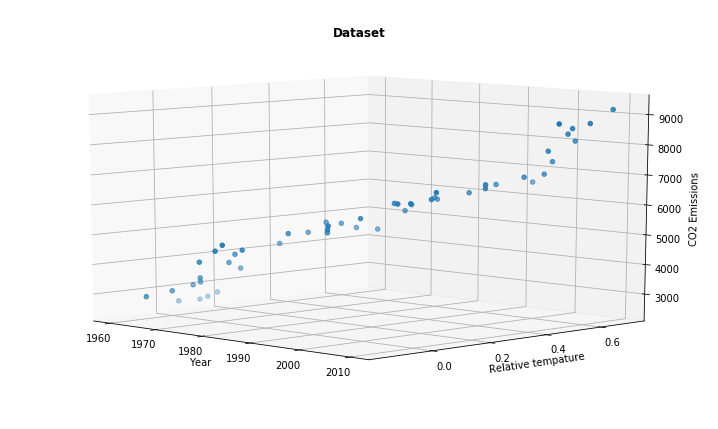

In [67]:
fig = plt.figure()
fig.set_size_inches(12.5, 7.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=climate_change_df['Year'], ys=climate_change_df['Temperature'], zs=climate_change_df['CO2'])

ax.set_ylabel('Relative tempature'); ax.set_xlabel('Year'); ax.set_zlabel('CO2 Emissions')
ax.view_init(10, -45)

Normalization of the data to get all axis between 0 and 1 so the output layer of the network can be a sigmoid

In [54]:
Dinput=np.array([climate_change_df['Year'],climate_change_df['Temperature']]).T
Doutput=np.array([climate_change_df['CO2']],dtype=np.float).T
Dinput= Dinput-np.amin(Dinput, axis=0)
Dinput= Dinput/(1.4*np.amax(Dinput, axis=0))
Doutput= Doutput-np.amin(Doutput.ravel())
Doutput=Doutput/(1.4*np.max(Doutput.ravel()))

# Fiting the dataset with the Neural Network

In [55]:
#Create a meshgrid to plot all the 2D space where our 1D data manifold lies
X = np.arange(0, 1, 0.01,dtype=np.float)
Y = np.arange(0, 1, 0.01,dtype=np.float)
X, Y = np.meshgrid(X, Y)
S=X.shape

#Generate the network
#1st argument is learning rate
#2nd argument is momentum term
#3rd argument is number of epoch
#4th argument is number of neurons on the 1st hidden layer
#5th argument is number of neurons on the 2nd hidden layer
NN=Neural_Network(0.075,0.3,100000,5,5)

#training
#1st argument is a 2D array with input values (here [year (normalized), Relative temperature (normalized)])
#2nd argument is 1D array with output values (here CO2 emissions (normalized))
NN.trainMomentum(np.array([Dinput[:,0],Dinput[:,1]]).T,Doutput[:])

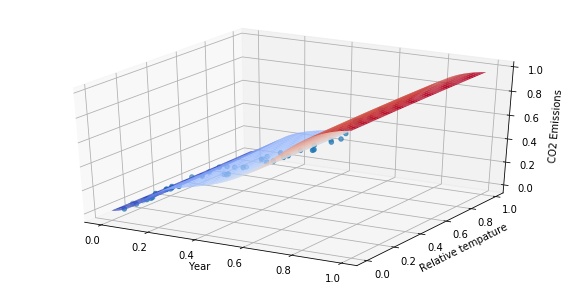

In [63]:
#Generating graph of the output fit
#Meshgrid as a vector to be fitted
Y=Y.ravel()
X=X.ravel()
Z=np.zeros_like(X)

#loop over elements of the meshgrid
for i in range(len(Y)):
    #forward pass of each element
    movingInput=np.array([X[i],Y[i]]).T
    Z[i]=NN.forward(movingInput)

#Reshaping it as a 2D matrix so it can be shown as a surface
X=X.reshape(S)
Y=Y.reshape(S)
Z=Z.reshape(S)

#plot in 3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z,cmap='coolwarm')
ax.scatter3D(xs=Dinput.T[0], ys=Dinput.T[1], zs=Doutput.T)
ax.set_ylabel('Relative tempature'); ax.set_xlabel('Year'); ax.set_zlabel('CO2 Emissions')
plt.show()

# Comparing the evolution of the loss using Gradient Descent with different Learning Rate

## Standard gradient descent

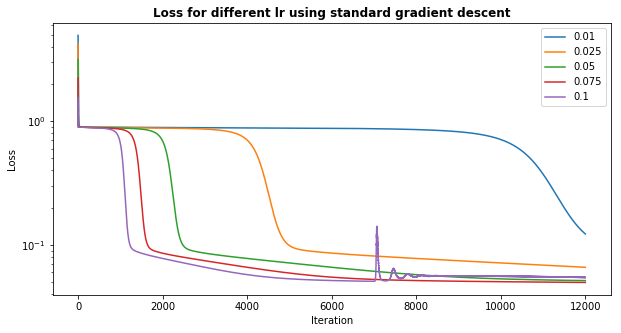

In [68]:
#Creating list with the learning rate that are to be tested
LearningRateArray=[0.01,0.025,0.05, 0.075, 0.1]
#Iterating over the learning rates
for i in LearningRateArray:
    #Creating a Neural network with 2 hidden layers of 3 neurons each
    NN=Neural_Network(i,0,12000,3,3)
    #training on 12000 epochs (iteration in this case since it is full batch)
    NN.train(Dinput,Doutput)
    #plot on log scale
    plt.plot(range(len(NN.costArray)),NN.costArray,label=str(i))
    plt.yscale('log')

plt.title('Loss for different lr using standard gradient descent',fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

## Gradient descent with momentum (fixed momentum = 0.5)

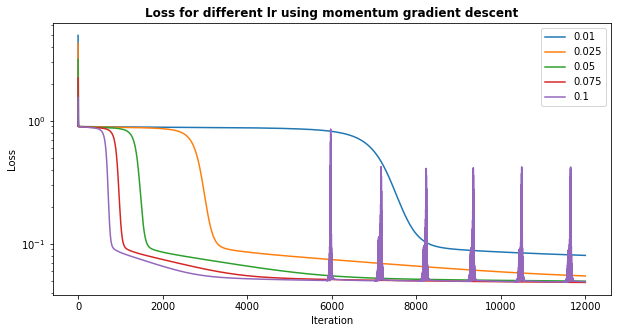

In [69]:
#Creating list with the learning rate that are to be tested
#Fixed momentum term at 0.5 so we can see oscillating states
LearningRateArray=[0.01,0.025,0.05, 0.075, 0.1]
for i in LearningRateArray:
    #Creating a Neural network with 2 hidden layers of 3 neurons each
    NN=Neural_Network(i,0.5,12000,3,3)
    #training with momentum on 12000 epochs (iteration in this case since it is full batch)
    NN.trainMomentum(Dinput,Doutput)
    plt.plot(range(len(NN.costArray)),NN.costArray,label=str(i))
    plt.yscale('log')
    
plt.title('Loss for different lr using momentum gradient descent',fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

## Evaluating speed up from momentum

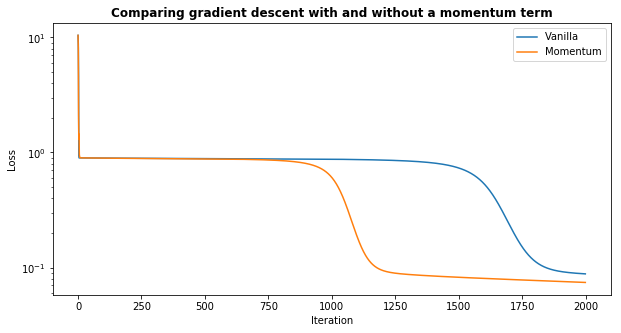

In [70]:
#Declaration of hyper parameters
LearningRate=0.075
Momentum=0.5
loops=2000
neurons=5

#Initializing the neural network (using standard gradient descent)
NN=Neural_Network(LearningRate,Momentum,loops,neurons,neurons)
#training on our dataset
NN.train(Dinput,Doutput)
plt.plot(range(len(NN.costArray)),NN.costArray,label='Vanilla')
plt.yscale('log')

#Initializing the neural network (using gradient descent with momentum)
NN=Neural_Network(LearningRate,Momentum,loops,neurons,neurons)
#training on our dataset
NN.trainMomentum(Dinput,Doutput)
plt.plot(range(len(NN.costArray)),NN.costArray,label='Momentum')
plt.yscale('log')

plt.title('Comparing gradient descent with and without a momentum term',fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()